# Домашнее задание (28 баллов)

* Для задачи 1 используйте данные:[сеть](https://drive.google.com/file/d/1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5/view?usp=sharing), [метки вершин](https://colab.research.google.com/drive/1Im4CNTOLqj4u-gx8IvaeTRaSUxyYmcH3#scrollTo=zNLwH-PzWdUb). 

* Для задачи 2,3 [данные](https://snap.stanford.edu/data/email-Eu-core.html) (предварительно сделайте сеть ненаправленной).

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn import metrics
from sklearn import tree
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 
import itertools
from community import community_louvain
from networkx.algorithms import community as com
from sklearn.metrics import mutual_info_score
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering
from google.colab import drive
import random
%matplotlib inline

## 1. Классификация вершин (10 баллов) 

Будем решать задачу предсказания влиятельности вершин как задачу бинарной классификации. 

1. (2 балла) Разметьте вершины (подсказка: постройте распределение влиятельностей и выберите порог разбиения на два отрезка).  

2. (2 балла) Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core.

3. (2 балла) Будем использовать структурный признак как простейший классификатор. Постройте соответсвующие ROC кривые и вычислите площади. 

4. (2 балла) Разделите выборку на обучающую и тестовую, постройте модели классификации (например, логистическая регрессия, SVM, дерево решений), используя все структурные признаки; выведите метрики качества.

5. (2 балла) Проанализируйте важность признаков. 

In [ ]:
#from google.colab import files
#files.upload()
import gdown

!gdown --id 1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1W5GrHAvxG4AjFm6kzwNyzoAA7jt48cJ5
To: /content/gdrive/MyDrive/анализ/ДЗ2/ca-GrQc.mtx
100% 140k/140k [00:00<00:00, 47.4MB/s]


In [ ]:
!gdown --id 1dC-PWLIE2xGbHZwEgfplICTYZdCvwVxC # данные по распространению

/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1dC-PWLIE2xGbHZwEgfplICTYZdCvwVxC
To: /content/gdrive/MyDrive/анализ/ДЗ2/spreading_data_ca-GrQc.csv
100% 113k/113k [00:00<00:00, 37.7MB/s]


In [ ]:
G=nx.read_adjlist('ca-GrQc.mtx')
print(G.number_of_nodes(),G.number_of_edges())

4158 13422


1. (2 балла) Разметьте вершины (подсказка: постройте распределение влиятельностей и выберите порог разбиения на два отрезка).  

<Axes: >

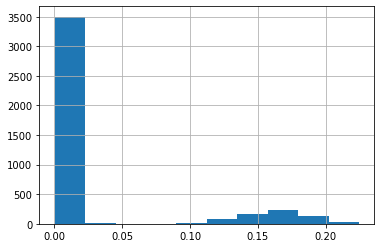

In [ ]:
df['spreading ability'].hist(bins=10)

In [ ]:
print(len(df[df['spreading ability']>0.07]))
print(len(df[df['spreading ability']<0.07]))

640
3518


In [ ]:
data=[]
for j in range (4158):
  if df['spreading ability'][j]<0.07:
    data.append(0)
  else:
    data.append(1)
df.loc[:, "nodes"] = data

2. (2 балла) Вычислите различные структурные признаки вершин: центральности, кластеризацию, k-core.

In [ ]:
df.loc[:, "degee_cen"]=list(nx.degree_centrality(G).values())
df.loc[:, "closeness_cen"]=list(nx.closeness_centrality(G).values())
df.loc[:, "harmonic_cen"]=list(nx.harmonic_centrality(G).values())
df.loc[:, "betweenness_cen"]=list(nx.betweenness_centrality(G).values())
df.loc[:, "eigenvector_cen"]=list(nx.eigenvector_centrality(G).values())
df.loc[:, "pagerank_cen"]=list(nx.pagerank(G, alpha=1.0).values())
df.loc[:, "clustering"]=list(nx.clustering(G).values())
df

,node,spreading ability,Class,Bet_centr,Clustering,Deg_centr,Eig_centr,Clos_centr,PR,nodes,degee_cen,closeness_cen,harmonic_cen,betweenness_cen,eigenvector_cen,pagerank_cen,clustering
0,19,0.000241,0,0.002893,0.500000,0.000962,1.978526e-07,0.184101,0.000187,0,0.000962,0.184101,982.252886,0.002893,1.978526e-07,0.000187,0.500000
1,1,0.000481,0,0.002290,0.333333,0.001443,1.930278e-08,0.159047,0.000294,0,0.001443,0.159047,710.653427,0.002290,1.930278e-08,0.000294,0.333333
2,1751,0.131073,1,0.000000,1.000000,0.000722,1.893130e-08,0.158980,0.000142,1,0.000722,0.158980,803.936941,0.000000,1.893130e-08,0.000142,1.000000
3,2408,0.000241,0,0.001707,0.400000,0.001203,5.769050e-07,0.171225,0.000229,0,0.001203,0.171225,810.569589,0.001707,5.769050e-07,0.000229,0.400000
4,3078,0.001684,0,0.000481,0.333333,0.000722,1.450752e-08,0.146260,0.000144,0,0.000722,0.146260,540.837299,0.000481,1.450752e-08,0.000144,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,3858,0.000241,0,0.000000,0.000000,0.000241,2.516598e-08,0.147349,0.000043,0,0.000241,0.147349,752.069589,0.000000,2.516598e-08,0.000043,0.000000
4154,3859,0.000241,0,0.000000,1.000000,0.000481,6.328154e-07,0.180261,0.000084,0,0.000481,0.180261,749.826587,0.000000,6.328154e-07,0.000084,1.000000
4155,4019,0.000241,0,0.000000,0.000000,0.000241,9.752772e-07,0.168655,0.000043,0,0.000241,0.168655,613.322475,0.000000,9.752772e-07,0.000043,0.000000
4156,4124,0.000241,0,0.000000,0.000000,0.000241,2.715108e-08,0.150550,0.000043,0,0.000241,0.150550,711.839214,0.000000,2.715108e-08,0.000043,0.000000


In [ ]:
cores=nx.core_number(G)
cores_list=sorted(cores,key=cores.get,reverse=True)
df.loc[:, "k_core"]=cores_list
df

,node,spreading ability,Class,Bet_centr,Clustering,Deg_centr,Eig_centr,Clos_centr,PR,nodes,degee_cen,closeness_cen,harmonic_cen,betweenness_cen,eigenvector_cen,pagerank_cen,clustering,k_core
0,19,0.000241,0,0.002893,0.500000,0.000962,1.978526e-07,0.184101,0.000187,0,0.000962,0.184101,982.252886,0.002893,1.978526e-07,0.000187,0.500000,98
1,1,0.000481,0,0.002290,0.333333,0.001443,1.930278e-08,0.159047,0.000294,0,0.001443,0.159047,710.653427,0.002290,1.930278e-08,0.000294,0.333333,6
2,1751,0.131073,1,0.000000,1.000000,0.000722,1.893130e-08,0.158980,0.000142,1,0.000722,0.158980,803.936941,0.000000,1.893130e-08,0.000142,1.000000,118
3,2408,0.000241,0,0.001707,0.400000,0.001203,5.769050e-07,0.171225,0.000229,0,0.001203,0.171225,810.569589,0.001707,5.769050e-07,0.000229,0.400000,251
4,3078,0.001684,0,0.000481,0.333333,0.000722,1.450752e-08,0.146260,0.000144,0,0.000722,0.146260,540.837299,0.000481,1.450752e-08,0.000144,0.333333,351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4153,3858,0.000241,0,0.000000,0.000000,0.000241,2.516598e-08,0.147349,0.000043,0,0.000241,0.147349,752.069589,0.000000,2.516598e-08,0.000043,0.000000,3815
4154,3859,0.000241,0,0.000000,1.000000,0.000481,6.328154e-07,0.180261,0.000084,0,0.000481,0.180261,749.826587,0.000000,6.328154e-07,0.000084,1.000000,3858
4155,4019,0.000241,0,0.000000,0.000000,0.000241,9.752772e-07,0.168655,0.000043,0,0.000241,0.168655,613.322475,0.000000,9.752772e-07,0.000043,0.000000,4019
4156,4124,0.000241,0,0.000000,0.000000,0.000241,2.715108e-08,0.150550,0.000043,0,0.000241,0.150550,711.839214,0.000000,2.715108e-08,0.000043,0.000000,4124


3. (2 балла) Будем использовать структурный признак как простейший классификатор. Постройте соответсвующие ROC кривые и вычислите площади. 

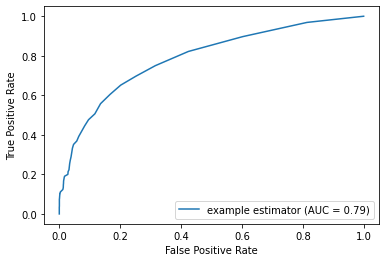

In [ ]:
y = df['nodes']
pred = df['degee_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

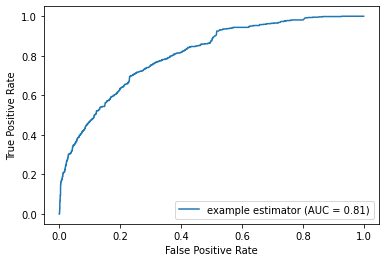

In [ ]:
y = df['nodes']
pred = df['closeness_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

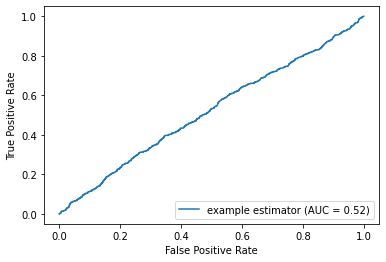

In [ ]:
y = df['nodes']
pred = df['harmonic_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

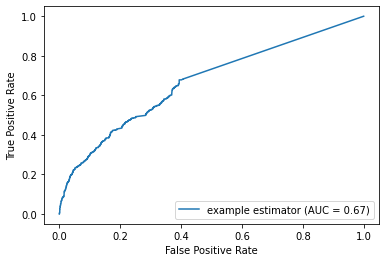

In [ ]:
y = df['nodes']
pred = df['betweenness_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

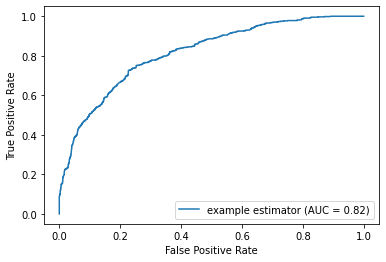

In [ ]:
y = df['nodes']
pred = df['eigenvector_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

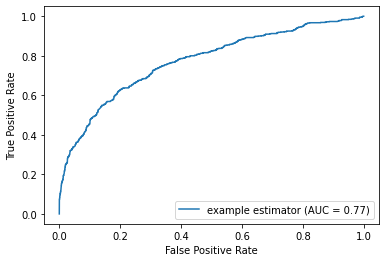

In [ ]:
y = df['nodes']
pred = df['pagerank_cen']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

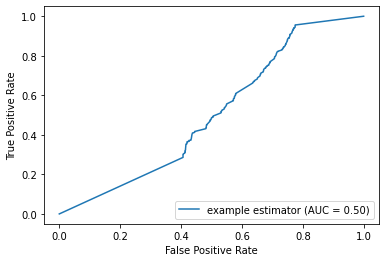

In [ ]:
y = df['nodes']
pred = df['clustering']
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.show()

4. (2 балла) Разделите выборку на обучающую и тестовую, постройте модели классификации (например, логистическая регрессия, SVM, дерево решений), используя все структурные признаки; выведите метрики качества.

In [ ]:
x=df[['degee_cen','closeness_cen','harmonic_cen','betweenness_cen','eigenvector_cen','pagerank_cen','clustering']]
y=df['Class']
x_train,x_test,y_train,y_test = train_test_split (x,y,test_size=0.25) 

In [ ]:
log = LogisticRegression()
log.fit (x_train,y_train)
y_pred = log.predict(x_test)
score = log.score(x_test, y_test)
print(score)

0.8451923076923077


In [ ]:
cnf_matrix = metrics. confusion_matrix (y_test, y_pred)
cnf_matrix

array([[869,  10],
       [114,  47]])

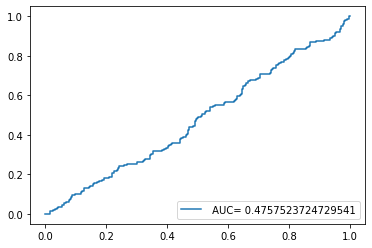

In [ ]:
y_pred_test = log.predict_proba (x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve (y_test, y_pred_test)
auc = metrics. roc_auc_score (y_test, y_pred_test)
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.legend(loc=4)
plt.show()

In [ ]:
scaler = StandardScaler() 
scaler.fit(x_train) 
lin = LinearSVC(C=0.01,random_state=35) 
lin.fit(scaler.transform(x_train), y_train) 
y_pred = lin.predict(scaler.transform(x_test)) 
score = lin.score(x_test, y_test)
print(score)

0.1548076923076923


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


In [ ]:
cnf_matrix = metrics.confusion_matrix (y_test, y_pred)
cnf_matrix

array([[869,  10],
       [114,  47]])

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]).ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print('precision= ',precision)
print('recall= ', recall)

precision=  0.8245614035087719
recall=  0.2919254658385093


In [ ]:
tree = tree.DecisionTreeClassifier()
tree. fit (x_train,y_train)
y_pred = tree.predict (x_test)
score = tree.score(x_test, y_test)
print(score)

0.8192307692307692


In [ ]:
cnf_matrix = metrics. confusion_matrix (y_test, y_pred)
cnf_matrix

array([[779, 100],
       [ 88,  73]])

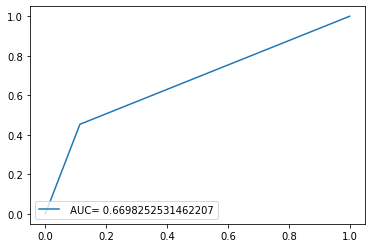

In [ ]:
y_pred_test = tree.predict_proba (x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)
auc = metrics.roc_auc_score (y_test, y_pred_test)
plt.plot (fpr,tpr,label=" AUC= "+str(auc))
plt.legend(loc=3)
plt.show()

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred, labels = [0, 1]).ravel()
precision=tp/(tp+fp)
recall=tp/(tp+fn)
print('precision= ',precision)
print('recall= ', recall)

precision=  0.398876404494382
recall=  0.4409937888198758


5. (2 балла) Проанализируйте важность признаков. 

Исходя из графиков ROCи площади под ними, наибольшей важностью облоадают Степень связности, Степень близости к другим узлам и Степень влиятельности

## 2. Предсказание связей (10 баллов)

1. (2 балла) Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована). 

2. (2 балла) Сравните Roc-кривые для различных структурных характеристик ребер в сети. Какая лучше справляется с задачей предсказания связей по AUC ROC? 

3. (4 балла) Напишите функцию, вычисляющую  Average precision at K (ap@K), определите зависимость ap@K от K для простейших классификаторов, определенных в 2. 

5. (2 балла) Постройте модель предсказания на основе вложения (используйте вложение сети с помощью Лапласиана или Node2vec, на выбор) Сравните качество предсказания с простейшими классификаторами. 



In [ ]:
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/"My Drive"/"анализ"/"ДЗ2"

Mounted at /content/gdrive
/content/gdrive/My Drive/анализ/ДЗ2


In [ ]:
G = nx.read_edgelist('email-Eu-core.txt') 
G = nx.Graph.to_undirected(G)
labels = pd.read_csv('email-Eu-core-department-labels.txt', sep=' ', names=['node', 'label'])

1. (2 балла) Разбейте сеть на обучающую и тестовую выборку, тестовая выборка должна содержать как связи, которые нужно предсказать, так и отсутствующие (выберите их случайным образом, чтобы тестовая выборка была сбалансирована). 

In [ ]:
test=random.sample(sorted(G.edges()), int(0.25*G.number_of_edges()))
test_non_nds=list(nx.non_edges(G))
test.extend(test_non_nds)
G_train=G.copy()
G_train.remove_edges_from(test)
G_test=test=nx.Graph()
G_test.add_edges_from(test)

## 3. Задача кластеризации (8 баллов)

 Каждый сотдрудник относится к одному из департаментов, которые и являются истинными сообществами в сети. 

1.  ( 2 балла) Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем? 

2. ( 2 балла) напишите функцию, вычисляющую [Rand индекс](https://en.wikipedia.org/wiki/Rand_index).

3. (2 балла) Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества (Rand индекс, взаимная энтропия, модулярность)  от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному? 

3. (2 балла) Определите сообщества любым другим методом (из семинара 9). Сколько сообществ вы получили? Сравните метрики качества. 


1.  ( 2 балла) Постройте распределение размеров сообществ в сети, какова доля вершин в наибольшем сообществе? В наименьшем? 

Доля вершин в наибольшем сообществе: 0.10845771144278607
Доля вершин в наименьшем сообществе: 0.0009950248756218905


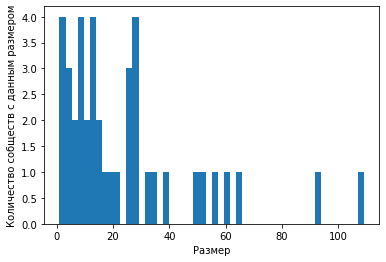

In [ ]:
clusters = labels['label'][np.argmax(labels['label'])]
current= 0  
community = []
for i in range(clusters):
  for node in labels['label']:
    if node == i:
      current += 1
  community.append(current)
  current = 0
plt.hist(community, bins=50)
plt.xlabel("Размер")
plt.ylabel("Количество собществ с данным размером")
nodes = G.number_of_nodes()
print("Доля вершин в наибольшем сообществе:",community[np.argmax(community)]/nodes)
print("Доля вершин в наименьшем сообществе:",community[np.argmin(community)]/nodes)

2. ( 2 балла) напишите функцию, вычисляющую [Rand индекс](https://en.wikipedia.org/wiki/Rand_index).

In [ ]:
def RandIndex(y_true, y_pred):
  if len(y_true) != len(y_pred):
    return 0
  a00 = 0
  a11 = 0
  a10 = 0
  a01 = 0
  N = len(y_true)
  for i in range(N):    
    for j in range(N):  
      if i != j:        
        if y_true[i] == y_true[j] and y_pred[i] == y_pred[j]:
          a00 += 1
        if y_true[i] != y_true[j] and y_pred[i] == y_pred[j]:
          a01 += 1
        if y_true[i] == y_true[j] and y_pred[i] != y_pred[j]:
          a10 += 1
        if y_true[i] != y_true[j] and y_pred[i] != y_pred[j]:
          a11 += 1
  rand_in=(a00 + a11) / (a00 + a11 + a01 + a10)
  jac_in= a00 / (a00 + a01 + a10)
  return rand_in, jac_in

3. (2 балла) Рассмотрим задачу поиска сообществ с помощью агломеративного метода, постройте зависимость метрик качества (Rand индекс, взаимная энтропия, модулярность)  от числа задаваемых сообществ. 
Какое разбиение оказывается более близким к истинному? 

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_agglomerative.py:544: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix l

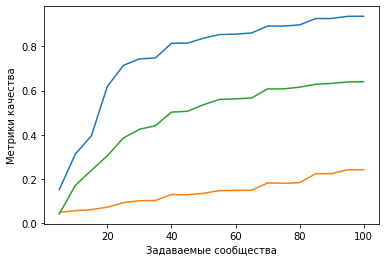

In [ ]:
def similarity_matrix(G, nodelist=None):
    if (nodelist is None):
        nodelist=list(G.nodes)

    Smatrix=np.zeros((len(nodelist), len(nodelist)))

    for i, node1 in enumerate(nodelist):
        for j, node2 in enumerate(nodelist[i+1:], start = i+1):
            Smatrix[i,j]=(len(set(G[node1]) & set(G[node2])) + int(G.has_edge(node1,node2)))/(np.min([len(G[node1]),len(G[node2])])
                                                                                          +1-int(G.has_edge(node1,node2)))
            Smatrix[j,i]=Smatrix[i,j]

    return Smatrix

N = 5
steps = 20
list_clust = np.linspace(N, steps*5, num=steps, dtype=int)
SM = similarity_matrix(G, nodelist=None)
communities = [] 
y_pred = []     
j = 0
for i in list_clust:
  X = SM.copy()
  communities.append(AgglomerativeClustering(linkage='average', n_clusters = i))
  communities[j].fit(X)
  y_pred.append(communities[j].labels_)
  j += 1
y_true = np.array(labels['label'])
randi_list = []
jaci_list = []
muti_list = []
for i in range(steps):
  rand_in, jac_in = RandIndex(y_true, y_pred[i])
  randi_list.append(rand_in)
  jaci_list.append(jac_in)
  muti_list.append(normalized_mutual_info_score(y_true, y_pred[i]))
plt.plot(list_clust, randi_list)
plt.plot(list_clust, jaci_list)
plt.plot(list_clust, muti_list)
plt.xlabel("Задаваемые сообщества")
plt.ylabel("Метрики качества")
commun = []  
comms = []     
cur_com = []   
for i in range(steps):
  for j in range(list_clust[i]):
    for node_in in range(len(y_pred[i])):
      if y_pred[i][node_in] == j:
        cur_com.append(str(node_in))
    comms.append(cur_com)
    cur_com = []
  commun.append(comms)
  comms = []

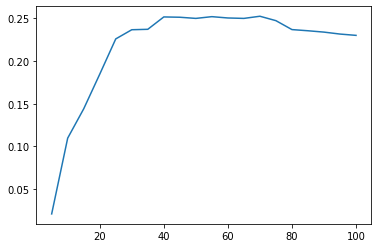

In [ ]:
modularities = []   
for i in range(steps):
  modularities.append(com.modularity(G, commun[i]))
plt.plot(list_clust, modularities)

3. (2 балла) Определите сообщества любым другим методом (из семинара 9). Сколько сообществ вы получили? Сравните метрики качества. 

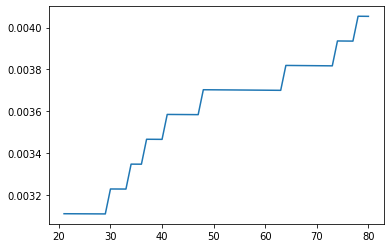

In [ ]:
lens = []
y_pred_alg = []
y_pred_alg_cur = []
modularities_alg = []
num = 60
g_n_comm = com.girvan_newman(G) 
for communities in itertools.islice(g_n_comm, num):
  l = list(list(c) for c in communities)
  mod = com.modularity(G, l)
  lens.append(len(l))
  modularities_alg.append(mod)
  for node in range(len(labels['node'])):
    for j in range(len(l)):
      if str(node) in l[j]:
        y_pred_alg_cur.append(j)
        break
  y_pred_alg.append(y_pred_alg_cur)
  y_pred_alg_cur = []
plt.plot(lens, modularities_alg)

Text(0, 0.5, 'Метрики качества')

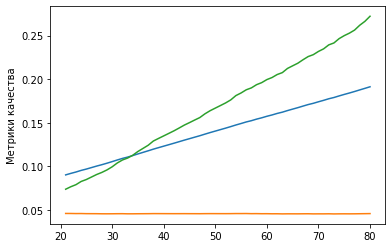

In [ ]:
randi_list_alg = []
jaci_list_alg = []
muti_list_alg = []
for i in range(len(y_pred_alg)):
  rand_in_alg, jac_in_alg = RandIndex(y_true, y_pred_alg[i])
  randi_list_alg.append(rand_in_alg)
  jaci_list_alg.append(jac_in_alg)
  muti_list_alg.append(mutual_info_score(y_true, y_pred_alg[i]))
plt.plot(lens, randi_list_alg)
plt.plot(lens, jaci_list_alg)
plt.plot(lens, muti_list_alg)
plt.ylabel("Метрики качества")

In [ ]:
from community import community_louvain

lv = community_louvain.best_partition(G)
coms = []
for i in range(max(lv.values()) + 1):
    coms.append(set(n for n in G.nodes() if (lv[n] == i)))

print("Модулярность:", com.modularity(G,coms))
print("Количество кластеров:", len(coms))

Модулярность: 0.4320995936958587
Количество кластеров: 27
